In [1]:
from PIL import Image
import numpy as np
import pandas as pd
from glob import glob
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import confusion_matrix, accuracy_score


In [2]:
##Split data into 75%/25% training/test splits

training_set = []
for n in range(1,13):
    plays = glob("data/*game_{}_*".format(str(n)))
    for play in plays:
        training_set.append(play)

test_set = []
for n in range(13,17):
    plays = glob("data/*game_{}_*".format(str(n)))
    for play in plays:
        test_set.append(play)

In [3]:
def process_data(file_list, target_feature):
    '''Takes the play traces, crops them so that they all have the same shape 
       (200x250), reshapes the matrix into a 1-d array, and returns the play
       array and its label for the target_feature'''
    X = []
    Y = []
    for f in file_list:
        data = pd.read_csv(f)
        data['formation_and_play'] = data['formation'] + '-' + data['playcall']
        x = data[[i for i in list(data.columns) if i not in  ['playcall', 'formation', 'formation_and_play']]]
        x.columns = x.columns.map(int)
        
        ## Crop the matrix
        x = x.loc[:250][[i for i in list(x.columns) if i >= -100 and i < 100 ]]
        y = data[target_feature].unique()
        X.append(np.reshape(x.as_matrix(),50000))
        Y.append(y)
    return X, Y

In [4]:
X_train_formation, y_train_formation = process_data(training_set, 'formation')
X_test_formation, y_test_formation = process_data(test_set, 'formation')

/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:16: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  app.launch_new_instance()


In [5]:
X_train_playcall, y_train_playcall = process_data(training_set, 'playcall')
X_test_playcall, y_test_playcall = process_data(test_set, 'playcall')

/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:16: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  app.launch_new_instance()


In [6]:
X_train_formation_play, y_train_formation_play = process_data(training_set, 'formation_and_play')
X_test_formation_play, y_test_formation_play = process_data(test_set, 'formation_and_play')

/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:16: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  app.launch_new_instance()


In [7]:
## Fit 3 different stochastic gradient descent models on the training data. 
## Model 1: Predict formation
## Model 2: Predit play
## Model 3: Predict formation and play at same time

formation_model = SGDClassifier(random_state=42, max_iter=1000, tol=1e-3)
formation_model.fit(X_train_formation, y_train_formation)
playcall_model = SGDClassifier(random_state=42, max_iter=1000, tol=1e-3)
playcall_model.fit(X_train_playcall, y_train_playcall)
formation_play_model = SGDClassifier(random_state=42, max_iter=1000, tol=1e-3)
formation_play_model.fit(X_train_formation_play, y_train_formation_play)



/anaconda/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=1000, n_iter=None,
       n_jobs=1, penalty='l2', power_t=0.5, random_state=42, shuffle=True,
       tol=0.001, verbose=0, warm_start=False)

## Model 1: Predict Formation

In [8]:
preds_formation = formation_model.predict(X_test_formation)
conf_formation = pd.DataFrame(confusion_matrix(y_test_formation, preds_formation), columns = np.unique([y_test_formation]))
conf_formation.rename({0: conf_formation.columns[0], 1: conf_formation.columns[1], 
                       2: conf_formation.columns[2]})

,three_by_one_left,three_by_one_right,two_by_two
three_by_one_left,103,0,0
three_by_one_right,0,103,0
two_by_two,0,0,114


## Model 2: Predict Playcall

In [9]:
preds_playcall = playcall_model.predict(X_test_playcall)
conf_playcall = pd.DataFrame(confusion_matrix(y_test_playcall, preds_playcall), columns = np.unique([y_test_playcall]))
conf_playcall.rename({0: conf_playcall.columns[0], 1: conf_playcall.columns[1], 
                      2: conf_playcall.columns[2], 3: conf_playcall.columns[3], 
                      4: conf_playcall.columns[4], 5: conf_playcall.columns[5]})


,all_slant,crosses,four_verts,hitches,run,smash
all_slant,56,0,0,0,0,0
crosses,0,52,0,0,0,0
four_verts,0,0,71,0,0,0
hitches,0,0,0,44,0,0
run,0,0,0,0,53,0
smash,0,0,0,0,0,44


## Model 3: Predict formation and playcall

In [10]:
fp = {}
for n in range(0,len(np.unique([y_test_formation_play]))):
    fp[n] = np.unique([y_test_formation_play])[n]

In [11]:
preds_formation_play = formation_play_model.predict(X_test_formation_play)
conf_formation_play = pd.DataFrame(confusion_matrix(y_test_formation_play, preds_formation_play), 
                                   columns = np.unique([y_test_formation_play]))
conf_formation_play.rename(fp)

,three_by_one_left-all_slant,three_by_one_left-crosses,three_by_one_left-four_verts,three_by_one_left-hitches,three_by_one_left-run,three_by_one_left-smash,three_by_one_right-all_slant,three_by_one_right-crosses,three_by_one_right-four_verts,three_by_one_right-hitches,three_by_one_right-run,three_by_one_right-smash,two_by_two-all_slant,two_by_two-crosses,two_by_two-four_verts,two_by_two-hitches,two_by_two-run,two_by_two-smash
three_by_one_left-all_slant,19,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
three_by_one_left-crosses,0,22,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
three_by_one_left-four_verts,0,0,21,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
three_by_one_left-hitches,0,0,0,14,0,0,0,0,0,0,0,0,0,0,0,0,0,0
three_by_one_left-run,0,0,0,0,19,0,0,0,0,0,0,0,0,0,0,0,0,0
three_by_one_left-smash,0,0,0,0,0,8,0,0,0,0,0,0,0,0,0,0,0,0
three_by_one_right-all_slant,0,0,0,0,0,0,18,0,0,0,0,0,0,0,0,0,0,0
three_by_one_right-crosses,0,0,0,0,0,0,0,15,0,0,0,0,0,1,0,0,0,0
three_by_one_right-four_verts,0,0,0,0,0,0,0,0,21,0,0,0,0,0,0,0,0,0
three_by_one_right-hitches,0,0,0,0,0,0,0,0,0,15,0,0,0,0,0,0,0,0


## Accuracy report

In [12]:
formation_model_acc = accuracy_score(y_test_formation, preds_formation)
play_model_acc = accuracy_score(y_test_playcall, preds_playcall)
fp_model_acc = accuracy_score(y_test_formation_play, preds_formation_play)
print("Formation Model: {}% accuracy".format(formation_model_acc*100))
print("Play Model: {}% accuracy".format(play_model_acc*100))
print("Formation and Play Model: {}% accuracy".format(fp_model_acc*100))

Formation Model: 100.0% accuracy
Play Model: 100.0% accuracy
Formation and Play Model: 99.0625% accuracy


# Results

When formation and play are joined into one classifier, **accuracy is lost**. The classifier gets confused by the same play run out of different formations. It confused 2x2 smash with 3x1 smash, and 2x2 crosses with 3x1 crosses. 

This likely cause is thin data.

# Solution

This can be solved by using two different models to predict play and formation independently.

# Testing It Out

In [35]:
from playbook import *
    
def format_for_prediction(df):
    ## Converts 10 hz data to 2d matrix of player paths
    play_data = df[['qb_x', 'qb_y', 'f_x', 'f_y', 'x_x', 'x_y',          
                    'h_x', 'h_y','y_x', 'y_y', 'z_x', 'z_y', 'lt_x', 'lt_y',
                     'lg_x', 'lg_y', 'c_x','c_y', 'rg_x', 'rg_y', 'rt_x', 'rt_y']]

    paths = pd.DataFrame(0, index=range(-125,125),columns=range(-100,100))
    for index, row in play_data.iterrows():
        for n in range(0,22,2):
            x = play_data.columns[n]
            y = play_data.columns[n+1]
            x = row[x]
            y = row[y]
            paths.set_value(np.round(y), np.round(x), 1)
    paths = paths.loc[:250][[i for i in list(paths.columns) if i >= -100 and i < 100 ]]

    return paths

def plot_play(play):
    play = play.reindex(index=play.index[::-1])
    plt.imshow(play)
    
    
def make_prediction(play, model):
    return model.predict(np.reshape(play.as_matrix(),50000).reshape(1,-1))[0]

## Two by two smash route:

/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:16: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  app.launch_new_instance()


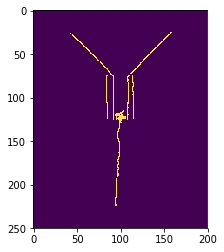

In [36]:
play = run_play(Playbook('two_by_two').smash)
play_traces = format_for_prediction(play)
plot_play(play_traces)

In [37]:
## Predict formation

make_prediction(play_traces, formation_model)

/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:27: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


'two_by_two'

In [38]:
## Predict play

make_prediction(play_traces, playcall_model)

/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:27: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


'smash'

## Four Verts from trips right:

/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:16: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  app.launch_new_instance()


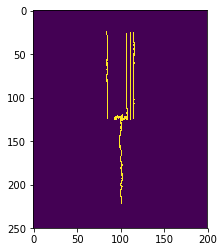

In [39]:
play = run_play(Playbook('three_by_one_right').four_verts)
play_traces = format_for_prediction(play)
plot_play(play_traces)

In [40]:
make_prediction(play_traces, formation_model)

/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:27: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


'three_by_one_right'

In [41]:
make_prediction(play_traces, playcall_model)

/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:27: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


'four_verts'